In this brief tutorial, we will go through how to implement a simple regression discontinuity design, using the functions in the rdd package.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from rdd import rdd

We are simulating a scenario where we want to estimate the causal effect of a treatment on an outcome, when treatment assignment is determined by whether an observed variable (the running variable) crosses a certain threshold.

E.g. a scholarship program where students receive a scholarship ('treatment') if their test score (running variable 'x') is above a certain 'threshold'. We want to study the effect of receiving the scholarship on students’ future academic performance (outcome 'y').

The Covariates (w1 and w2) are additional variables that might affect the outcome

N = samples

treatment = scolarship received

x = running variable (test score)

y = outcome = future performances

epsilon = error

w1,w2 = covariates confounding variables (eg socioeconomic status, academic performances)

In [2]:
# First, let's generate a dataset to work with.

# Number of observations
N = 10000

# Generate N random values from a normal distribution with mean 1 and standard deviation 1
# Simulates a realistic scenario where TEST SCORES are normally distributed around a mean.
x = np.random.normal(1, 1, N)

# Generate N random noise values from a normal distribution with mean 0 and standard deviation 1
epsilon = np.random.normal(0, 1, N)

# Define the threshold for treatment SCOLARSHIP assignment
threshold = 1

# Assign treatment based on whether x is greater than or equal to the threshold
treatment = np.where(x >= threshold, 1, 0)

# Covariates examples: Other factors like w1: students’ socioeconomic status or w2: prior academic performance.

# Generate N random values from a normal distribution with mean 0 and standard deviation 1 for covariate w1
w1 = np.random.normal(0, 1, N)

# Generate N random values from a normal distribution with mean 0 and standard deviation 4 for covariate w2
w2 = np.random.normal(0, 4, N)

# Define the outcome variable y as a function of treatment, x, w1, and epsilon.
# N.B. !!!!!!!!!!! ideally, we shouldn't calculate the outcome y from the features, but it should be already provided, and we should investigate the dependence of this outcome y with the features !!!!!!!!!!!!!
# The coefficients (0.5, 2, -0.2, and 1) are chosen to simulate a realistic relationship
# Simplification: In this specific simulation, w2 is included in the dataset but not used in the outcome equation to simplify the model. This allows us to focus on the primary variables of interest (treatment, x, and w1).
y = 0.9 * treatment + 1.6 * x - 0.2 * w1 + 1 + epsilon

# Create a DataFrame to store the generated data
data = pd.DataFrame({'y': y, 'x': x, 'w1': w1, 'w2': w2, 'treatment': treatment})

data

,y,x,w1,w2,treatment
0,2.042613,0.263149,0.318478,0.553659,0
1,0.901540,-0.049448,-0.310679,-3.117452,0
2,-0.769346,-0.486226,-1.136484,-3.563885,0
3,3.780290,1.964002,0.058918,6.984308,1
4,2.033590,0.426379,-0.322419,3.707808,0
...,...,...,...,...,...
9995,1.124314,0.495501,-0.779309,-1.105741,0
9996,4.795360,2.245984,-0.239535,-1.964076,1
9997,4.273529,1.473343,1.581563,0.672830,1
9998,5.150490,1.235621,-1.672333,0.183872,1


Restrict Data in a bandwidth

When running our RDD, we first want to choose a bandwidth that we will use to restrict our dataset to only analyze observations that are very close to the threshold. 

E.g. focusing only on students who scored close to the threshold (e.g., between 0.75 and 1.25 if the threshold is 1), we ensure that the students we are comparing are more similar. This makes it easier to isolate the effect of the scholarship (treatment).

In [3]:
# We can pick whatever bandwidth we like, or we can select the optimal bandwidth.

bandwidth_opt = rdd.optimal_bandwidth(data['y'], data['x'], cut=threshold)
print("Optimal bandwidth:", bandwidth_opt)

# being the threshold 1:
# Lower bound: ( threshold - bandwidth_opt )
# Upper Bound: ( threshold + bandwidth_opt )
# So, we include observations where ( x ) is between lower and upper bound

Optimal bandwidth: 0.43270794876012375


In [4]:
# Now let's restrict the dataset to be only observations within this bandwidth of the threshold.
# (Note: truncated_data() can also call optimal_bandwidth(), which saves you a step)

data_rdd = rdd.truncated_data(data, 'x', bandwidth_opt, cut=threshold)

print ('x range:', np.min(data_rdd.x),np.max(data_rdd.x))
print(data_rdd.treatment.value_counts())
data_rdd

x range: 0.5674891030101367 1.4322606165745773
treatment
1    1689
0    1596
Name: count, dtype: int64


,y,x,w1,w2,treatment
13,2.073866,0.709955,-0.121029,3.355945,0
16,2.400356,0.809256,-1.673560,0.870007,0
20,1.965423,1.170693,0.941462,1.185699,1
22,4.696144,1.178521,0.569013,-2.931474,1
25,2.916993,1.376134,1.428013,-0.948712,1
...,...,...,...,...,...
9983,3.794200,1.293415,-0.758332,4.737989,1
9984,1.469023,0.691605,-0.068507,-10.364263,0
9993,3.487972,0.759303,-0.438145,-2.168915,0
9998,5.150490,1.235621,-1.672333,0.183872,1


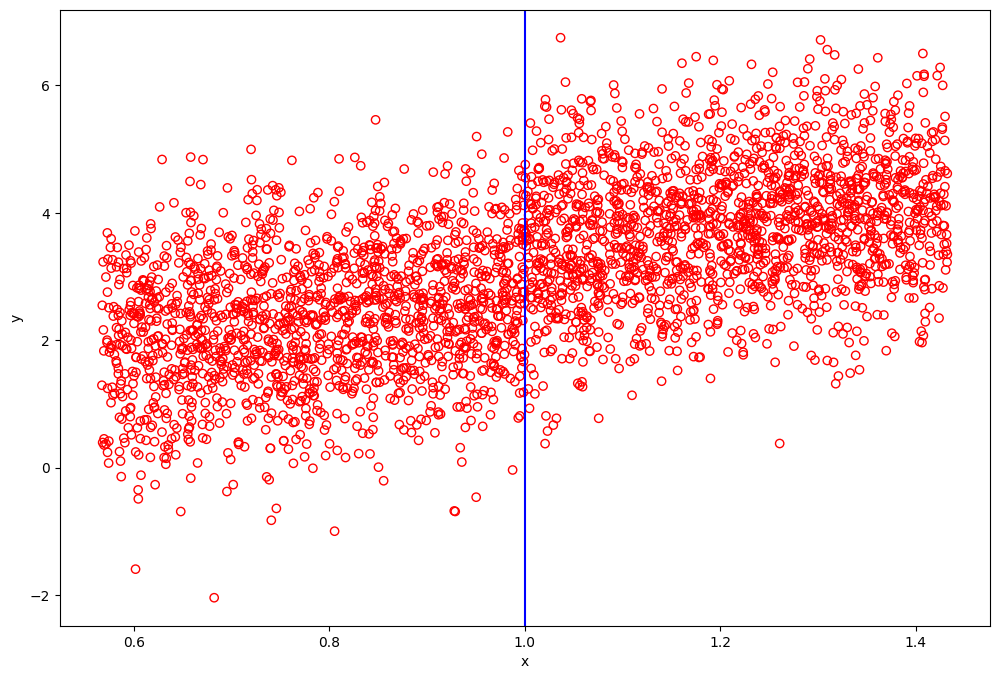

In [5]:
# Check for the Presence of a Discontinuity
# Before we move to estimation, let's see if graphically it even looks like there is a discontinuous change in the outcome at the threshold. We use a regular scatter plot.

plt.figure(figsize=(12, 8))
plt.scatter(data_rdd['x'], data_rdd['y'], facecolors='none', edgecolors='r')
plt.xlabel('x')
plt.ylabel('y')
plt.axvline(x=threshold, color='b')
plt.show()
plt.close()

In [6]:
# As you can see, it's really hard to tell what's going on at the threshold - it's far to noisy. So what we'll do is put the data into bins based on the running variable, get the average value of the outcome variable in each bin, then plot the result. This will allow us to parse through the noise.

data_binned = rdd.bin_data(data_rdd, 'y', 'x', 100) # creating 100 bins

data_binned

,0,y,x,n_obs
0,0.0,1.694822,0.571813,21.0
1,0.0,2.215856,0.580461,26.0
2,0.0,1.681878,0.589108,28.0
3,0.0,1.823762,0.597756,28.0
4,0.0,1.926472,0.606404,32.0
...,...,...,...,...
95,0.0,4.069451,1.393346,32.0
96,0.0,3.985897,1.401994,31.0
97,0.0,4.032283,1.410641,31.0
98,0.0,4.354805,1.419289,22.0


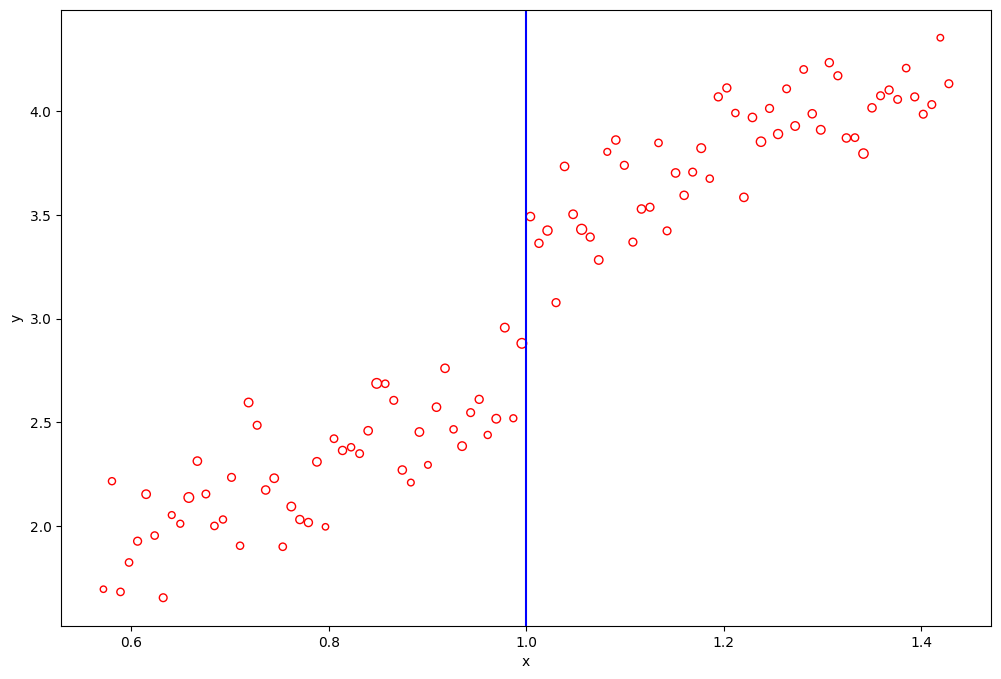

In [7]:
plt.figure(figsize=(12, 8))
plt.scatter(data_binned['x'], data_binned['y'],
    s = data_binned['n_obs'], facecolors='none', edgecolors='r') # bins can containg different number of samples, so the parameter 's' is used in the visualization to reflect their sizes
plt.axvline(x=threshold, color='b')
plt.xlabel('x')
plt.ylabel('y')
plt.show()
plt.close()

Estimation

All we have to do is estimate a simple linear regression of the outcome variable 'y' on a dummy variable for whether the observations lies to the right or left of the threshold (the model defines it, based on the threshold assigned to the parameter 'cut' and calls it TREATED), and the running variable 'x'plus eventually the other covariates:

y (outcome:performances) ~ TREATED + x (running:scores) + other covariates

We could do this ourselves, and we can also run rdd(). 

As the outcome y has been syntethically created: [y = 0.6 * treatment + 1.6 * x - 0.2 * w1 + 1 + epsilon], we already know what coefficients values to expect (in a real case, the outcome 'y' would be already given)

In [8]:
model = rdd.rdd(data_rdd, 'x', 'y', cut=threshold) # the TREATED binary feature will be calculated by the model, applying the threshold over the running variable 'x' (as the 'treatment' variable is calculated in the above equation)
print(model.fit().summary())

Estimation Equation:	 y ~ TREATED + x
                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.378
Model:                            WLS   Adj. R-squared:                  0.377
Method:                 Least Squares   F-statistic:                     995.7
Date:                Wed, 14 Aug 2024   Prob (F-statistic):               0.00
Time:                        16:20:25   Log-Likelihood:                -4698.5
No. Observations:                3285   AIC:                             9403.
Df Residuals:                    3282   BIC:                             9421.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     

In [9]:
model = rdd.rdd(data_rdd,
                'x', # The running variable (forcing variable) in the RDD
                'y', # The outcome variable
                cut=threshold, # The cutoff point for the running variable that determines treatment assignment
                controls=['w1', 'w2'] # Additional covariates included in the model to control for other factors
               )
print(model.fit(cov_type='hc1').summary()) # Fits the model using heteroscedasticity-consistent standard errors (HC1)

Estimation Equation:	 y ~ TREATED + x + w1 + w2
                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.404
Model:                            WLS   Adj. R-squared:                  0.403
Method:                 Least Squares   F-statistic:                     550.9
Date:                Wed, 14 Aug 2024   Prob (F-statistic):               0.00
Time:                        16:20:26   Log-Likelihood:                -4628.7
No. Observations:                3285   AIC:                             9267.
Df Residuals:                    3280   BIC:                             9298.
Df Model:                           4                                         
Covariance Type:                  hc1                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Inte

In [10]:
model = rdd.rdd(data_rdd, 'x', cut=threshold, equation='y ~ TREATED + x + w1*w2')
print(model.fit().summary())

Estimation Equation:	 y ~ TREATED + x + w1*w2
                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.404
Model:                            WLS   Adj. R-squared:                  0.403
Method:                 Least Squares   F-statistic:                     443.7
Date:                Wed, 14 Aug 2024   Prob (F-statistic):               0.00
Time:                        16:20:26   Log-Likelihood:                -4628.5
No. Observations:                3285   AIC:                             9269.
Df Residuals:                    3279   BIC:                             9306.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Interc

Validation: Placebo Tests

How can we check to see if our results are robust? One method is to repeat the analysis, using a fake threshold. This placebo test should result in a null treatment effect -- since the threshold is fake, nothing is inherently different for observations on either side. If we do still see a statistically significant coefficient on TREATED, that may be cause for alarm.

In [11]:
fake_threshold = 0.52

data_placebo = rdd.truncated_data(data, 'x', yname='y', cut=fake_threshold)
data_placebo.describe()

# being the threshold 0 and bandwidth 0.70379:
# Lower bound: ( threshold - bandwidth_opt )
# Upper Bound: ( threshold + bandwidth_opt )
# So, we include observations where ( x ) is between lower and upper bound

,y,x,w1,w2,treatment
count,2670.000000,2670.000000,2670.000000,2670.000000,2670.0
mean,1.872482,0.536731,-0.000947,0.045494,0.0
std,1.079882,0.222072,0.978145,3.993798,0.0
min,-2.418971,0.129687,-3.615124,-13.428517,0.0
25%,1.155708,0.347866,-0.658947,-2.649644,0.0
50%,1.871263,0.544181,0.009877,0.003209,0.0
75%,2.624139,0.731417,0.666595,2.731755,0.0
max,5.458009,0.910638,3.080670,13.091936,0.0


In [12]:
# compare with previous dataframe (with threshold at 1)
data_rdd.describe()

,y,x,w1,w2,treatment
count,3285.000000,3285.000000,3285.000000,3285.000000,3285.000000
mean,3.072415,1.006342,0.020463,-0.035691,0.514155
std,1.282220,0.244455,0.980427,4.031910,0.499876
min,-2.042337,0.567489,-3.670900,-13.428517,0.000000
25%,2.173749,0.794809,-0.627561,-2.814710,0.000000
50%,3.096463,1.011713,0.034601,0.002982,1.000000
75%,3.971399,1.220670,0.677699,2.756930,1.000000
max,6.746819,1.432261,3.080670,13.108375,1.000000


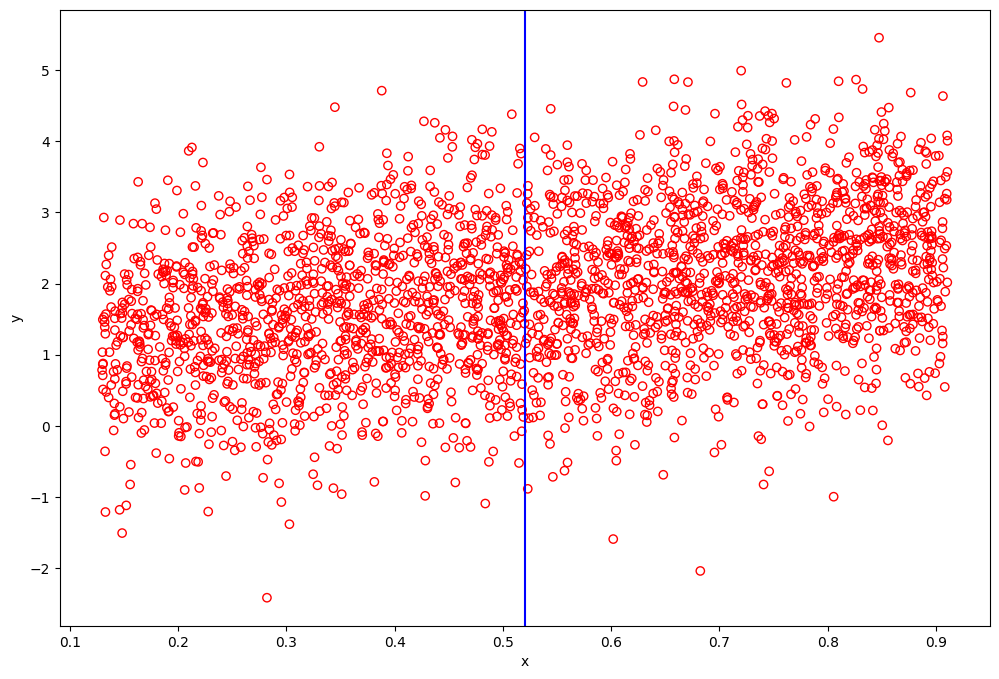

In [13]:
# Check for the Presence of a Discontinuity in data_placebo

plt.figure(figsize=(12, 8))
plt.scatter(data_placebo['x'], data_placebo['y'], facecolors='none', edgecolors='r')
plt.xlabel('x')
plt.ylabel('y')
plt.axvline(x=fake_threshold, color='b')
plt.show()
plt.close()

In [14]:
# binning for better visualization

data_placebo_binned = rdd.bin_data(data_placebo, 'y', 'x', 100) # creating 100 bins

data_placebo_binned

,0,y,x,n_obs
0,0.0,1.191527,0.133592,23.0
1,0.0,1.066413,0.141401,18.0
2,0.0,0.977672,0.149211,23.0
3,0.0,1.233427,0.157020,16.0
4,0.0,1.331577,0.164830,29.0
...,...,...,...,...
95,0.0,2.259121,0.875495,31.0
96,0.0,2.275294,0.883305,21.0
97,0.0,2.345045,0.891114,32.0
98,0.0,2.504139,0.898924,21.0


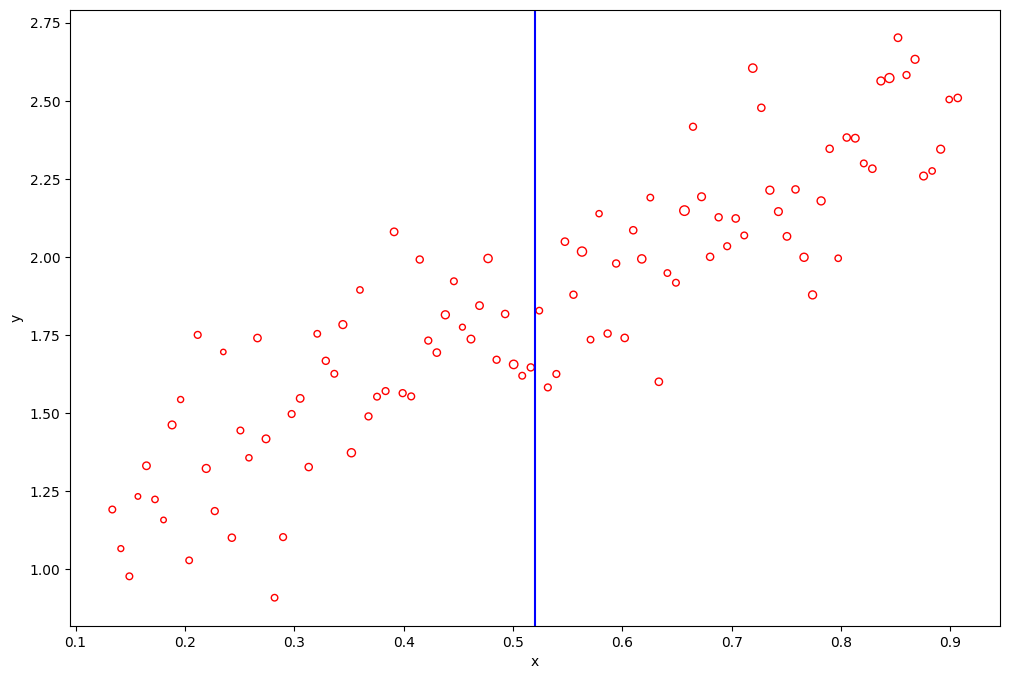

In [15]:
plt.figure(figsize=(12, 8))
plt.scatter(data_placebo_binned['x'], data_placebo_binned['y'],
    s = data_placebo_binned['n_obs'], facecolors='none', edgecolors='r') # bins can containg different number of samples, so the parameter 's' is used in the visualization to reflect their sizes
plt.axvline(x=fake_threshold, color='b') 
plt.xlabel('x')
plt.ylabel('y')
plt.show()
plt.close()

In [16]:
model = rdd.rdd(data_placebo, 'x', 'y', cut=fake_threshold, controls=['w1'])
print(model.fit().summary())

Estimation Equation:	 y ~ TREATED + x + w1
                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.148
Model:                            WLS   Adj. R-squared:                  0.147
Method:                 Least Squares   F-statistic:                     153.9
Date:                Wed, 14 Aug 2024   Prob (F-statistic):           5.40e-92
Time:                        16:20:26   Log-Likelihood:                -3780.0
No. Observations:                2670   AIC:                             7568.
Df Residuals:                    2666   BIC:                             7592.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept